In [2]:
!pip install pycm livelossplot

     |████████████████████████████████| 61kB 2.0MB/s 
     |████████████████████████████████| 542kB 8.0MB/s 


In [3]:
#imports
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from PIL import Image
import numpy as np
import random
from livelossplot import PlotLosses
from sklearn.metrics import accuracy_score
from torchvision import transforms



def set_seed(seed):
    """
    Use this to set ALL the random seeds to a fixed value and take out any randomness from cuda kernels
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.benchmark = False  ##uses the inbuilt cudnn auto-tuner to find the fastest convolution algorithms. -
    torch.backends.cudnn.enabled   = False

    return True

device = 'cpu'
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on GPU!")
    device = 'cuda'
else:
    print("No GPU available!")

No GPU available!


In [4]:
from google.colab import drive
drive.mount('/content/gdrive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive/


In [0]:
from albumentations import (VerticalFlip, HorizontalFlip, Flip, RandomRotate90, Rotate, ShiftScaleRotate, CenterCrop, OpticalDistortion, GridDistortion, ElasticTransform, JpegCompression, HueSaturationValue,
                            RGBShift, RandomBrightness, RandomContrast, Blur, MotionBlur, MedianBlur, GaussNoise, CLAHE, ChannelShuffle, InvertImg, RandomGamma, ToGray, PadIfNeeded, Compose 
                           )

In [0]:
#Just resize image for now
my_data = ImageFolder("/content/gdrive/My Drive/MSc/acse-miniproject/train/", transform = transforms.Compose([transforms.Resize(224),
#    transforms.RandomApply([transforms.RandomChoice([transforms.RandomCrop(size=[224, 224], padding=10), transforms.RandomAffine(0, translate=(0.1, 0.1))])]), # choose one or 0 transforms that make the image smaller
#    transforms.RandomApply([transforms.RandomChoice([transforms.RandomHorizontalFlip(), transforms.RandomRotation(10)])]), # choose one or zero transforms to rotate or flip the image
#    transforms.ToTensor(),
#    transforms.Normalize(means, stds)
]))

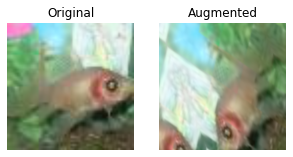

In [7]:
#Augmenting just one image first

fig, axarr = plt.subplots(1, 2, figsize=(5, 10))
ax = axarr.flatten()

#Define augmentations
augmentation = Compose([Rotate(limit=90, p=1.0),
                        HorizontalFlip(p=1.0),
                        ElasticTransform(p=1.0)], p=1.0)

og_img = np.asarray(my_data[0][0])
ax[0].imshow(og_img)
ax[0].set_title('Original')
ax[0].axis('off')

aug_img = augmentation(image=og_img)['image']
ax[1].imshow(aug_img)
ax[1].set_title('Augmented')
ax[1].axis('off')

plt.show()

In [0]:
from torchvision.datasets.folder import *
import os
import os.path

def my_make_dataset(directory, class_to_idx, extensions=None, is_valid_file=None):
    data = []
    targets = []
    directory = os.path.expanduser(directory)
    both_none = extensions is None and is_valid_file is None
    both_something = extensions is not None and is_valid_file is not None
    if both_none or both_something:
        raise ValueError("Both extensions and is_valid_file cannot be None or not None at the same time")
    if extensions is not None:
        def is_valid_file(x):
            return has_file_allowed_extension(x, extensions)
    for target_class in sorted(class_to_idx.keys()):
        class_index = class_to_idx[target_class]
        target_dir = os.path.join(directory, target_class)
        if not os.path.isdir(target_dir):
            continue
        for root, _, fnames in sorted(os.walk(target_dir, followlinks=True)):
            for fname in sorted(fnames):
                path = os.path.join(root, fname)
                if is_valid_file(path):
                    item = path, class_index
                    data.append(path)
                    targets.append(class_index)
    return data, targets

class AlbumentationImageFolder(ImageFolder):
    def __init__(self, root, extensions=IMG_EXTENSIONS, transform=None,
                 target_transform=None, is_valid_file=None):
        super(ImageFolder, self).__init__(root, default_loader, IMG_EXTENSIONS if is_valid_file is None else None,
                                          transform=transform,
                                          target_transform=target_transform,
                                          is_valid_file=is_valid_file)
        classes, class_to_idx = self._find_classes(self.root)
        #data, targets = my_make_dataset(self.root, class_to_idx, extensions, is_valid_file)
        '''if len(self.images) == 0:
            msg = "Found 0 files in subfolders of: {}\n".format(self.root)
            if extensions is not None:
                msg += "Supported extensions are: {}".format(",".join(extensions))
            raise RuntimeError(msg)'''

        self.classes = classes
        self.class_to_idx = class_to_idx
        #self.data = [self.loader(data[i]) for i in range(len(data))]
        #self.targets = targets
        self.imgs = self.samples
        self.aug = Compose([Rotate(limit=90),
                        HorizontalFlip(), #default p is 0.5 for all of them
                        ElasticTransform()], p=0.7)

    def __getitem__(self, idx):
        target = self.imgs[idx][1]
        sample = self.aug(image=np.array(self.imgs[idx][0]))['image']
        image = np.transpose(sample, (2, 0, 1)).astype(np.float32)
        image = torch.tensor(image, dtype=torch.float)
            
        return image, target


In [0]:
augmented_data = AlbumentationImageFolder("/content/gdrive/My Drive/MSc/acse-miniproject/train/")

AttributeError: ignored